In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,InputLayer, Dropout
from tensorflow.keras import metrics

In [3]:
# Load training data

df = pd.read_csv("train_wn75k28.csv")
df.head()

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
0,1,2021-01-01,1,2,2.0,2020-09-24,0,0,0,0,0,0,1,1,0,0,0,0,0
1,2,2021-01-01,2,1,2.0,2020-09-19,1,0,1,0,0,0,1,0,0,0,0,0,0
2,3,2021-01-01,9,3,3.0,2021-08-11,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2021-01-01,6,7,2.0,2017-10-04,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2021-01-01,4,6,NaN,2020-06-08,0,0,0,0,0,0,1,0,0,0,1,0,0


In [4]:
print("Shape of Training Data ",df.shape)

Shape of Training Data  (39161, 19)


In [5]:
#data = df[['campaign_var_1', 'campaign_var_2','user_activity_var_1','user_activity_var_2','user_activity_var_3','user_activity_var_4','user_activity_var_5','user_activity_var_6','user_activity_var_7','user_activity_var_8','user_activity_var_9','user_activity_var_10','user_activity_var_11','user_activity_var_12','buy']]


data = df[['user_activity_var_1','user_activity_var_2','user_activity_var_4','user_activity_var_5','user_activity_var_8','user_activity_var_9','user_activity_var_11','buy']]
data.head()

,user_activity_var_1,user_activity_var_2,user_activity_var_4,user_activity_var_5,user_activity_var_8,user_activity_var_9,user_activity_var_11,buy
0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0


In [6]:
neg_examples = data[data['buy']==0]
pos_examples = data[data['buy']==1]

# Shuffle Neg Examples
pos_examples = pos_examples.sample(frac=1).reset_index(drop=True)
neg_examples = neg_examples.sample(frac=1).reset_index(drop=True)

print("Shape of pos examples ", pos_examples.shape)
print("Shape of neg_examples ", neg_examples.shape)

Shape of pos examples  (1998, 8)
Shape of neg_examples  (37163, 8)


## CREATION OF TRAIN AND VALIDATION SETS

- Using 80:20 split ratio.
- Training set contains 80% of both pos and neg examples each.
- Validation set contains 20% of both pos and neg examples each.

In [7]:
pos_size = int(len(pos_examples) * 0.8)
neg_size = int(len(neg_examples) * 0.8)

### 1. Creating validation data set

In [8]:
# Creating validation data frame

val_pos = pos_examples.iloc[pos_size:len(pos_examples)]
val_neg = neg_examples.iloc[neg_size:len(neg_examples)]

val_data = pd.concat([val_pos, val_neg], ignore_index=True,axis=0)
val_data = val_data.sample(frac=1).reset_index(drop=True)
val_data.head()

,user_activity_var_1,user_activity_var_2,user_activity_var_4,user_activity_var_5,user_activity_var_8,user_activity_var_9,user_activity_var_11,buy
0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0


In [9]:
print(val_data.shape)

(7833, 8)


### 2. Creating Training set

In [10]:
train_pos = pos_examples.iloc[0:pos_size]
train_neg = neg_examples.iloc[0:neg_size]

print(train_pos.shape)
print(train_neg.shape)

(1598, 8)
(29730, 8)


In [11]:
# Since the data set is imbalanced. Using hybrid sampling technique

size_pos_train_examples = 3000
size_neg_train_examples = 10000

In [12]:
# Generating random numbers with replacement
pos_rand_index = np.random.randint(low=0, high=train_pos.shape[0], size=size_pos_train_examples)

train_pos_data = train_pos.iloc[pos_rand_index]
print(train_pos_data.shape)

(3000, 8)


In [13]:
rng = np.random.default_rng()
neg_rand_index = rng.choice(train_neg.shape[0], size=size_neg_train_examples, replace=False)

train_neg_data = train_neg.iloc[neg_rand_index]
print(train_neg_data.shape)

(10000, 8)


In [14]:
train_data = pd.concat([train_pos_data, train_neg_data], ignore_index=True,axis=0)
print(train_data.shape)

(13000, 8)


In [15]:
# Shuffle dataset

train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data.head()

,user_activity_var_1,user_activity_var_2,user_activity_var_4,user_activity_var_5,user_activity_var_8,user_activity_var_9,user_activity_var_11,buy
0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,1
4,1,0,0,0,0,0,0,0


### Model Training

In [16]:
train_data = train_data.to_numpy()
val_data = val_data.to_numpy()

print(train_data.shape)
print(val_data.shape)

(13000, 8)
(7833, 8)


In [17]:
train_x = train_data[:,0:train_data.shape[1]-1]
train_y = train_data[:,-1]

val_x = val_data[:, 0:val_data.shape[1]-1]
val_y = val_data[:,-1]

In [18]:
# Print training data shape

print(train_x.shape)
print(train_y.shape)

(13000, 7)
(13000,)


In [19]:
# Print validation data shape

print(val_x.shape)
print(val_y.shape)

(7833, 7)
(7833,)


In [20]:
model=Sequential()
model.add(InputLayer(input_shape=(7,)))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4096      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 70,018
Trainable params: 70,018
Non-trainable params: 0
_________________________________________________________________


2022-06-05 21:29:05.003568: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-05 21:29:05.004644: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [21]:
# Callbacks

#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5)

# Early Stoppping
EarlyStop = EarlyStopping( monitor='val_loss', patience=3, restore_best_weights=True)

In [22]:
#model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
history = model.fit(x=train_x, y=train_y, epochs=10, validation_data=(val_x,val_y),callbacks=[lrr, EarlyStop]) 

Epoch 1/10


2022-06-05 21:29:05.091279: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


407/407 [==============================] - 3s 5ms/step - loss: 0.3045 - accuracy: 0.8839 - val_loss: 0.1446 - val_accuracy: 0.9614
Epoch 2/10
407/407 [==============================] - 2s 4ms/step - loss: 0.2785 - accuracy: 0.8953 - val_loss: 0.1451 - val_accuracy: 0.9612
Epoch 3/10
407/407 [==============================] - 4s 10ms/step - loss: 0.2762 - accuracy: 0.8960 - val_loss: 0.1317 - val_accuracy: 0.9732
Epoch 4/10
407/407 [==============================] - 5s 12ms/step - loss: 0.2751 - accuracy: 0.8967 - val_loss: 0.1478 - val_accuracy: 0.9732
Epoch 5/10
407/407 [==============================] - 3s 7ms/step - loss: 0.2752 - accuracy: 0.8960 - val_loss: 0.1198 - val_accuracy: 0.9734
Epoch 6/10
407/407 [==============================] - 2s 6ms/step - loss: 0.2733 - accuracy: 0.8982 - val_loss: 0.1759 - val_accuracy: 0.9307
Epoch 7/10
407/407 [==============================] - 3s 6ms/step - loss: 0.2736 - accuracy: 0.8967 - val_loss: 0.1518 - val_accuracy: 0.9606
Epoch 8/10
407/

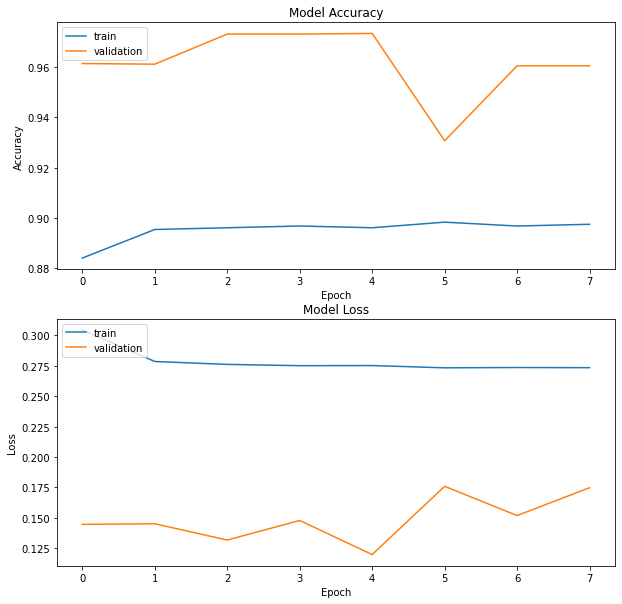

In [23]:
#plotting model accuracy for different epochs
plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc='upper left')   

# plotting model loss for different epochs
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()

### Evaluate model on validation data

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns

In [25]:
pred = model.predict(val_x)
y_pred = np.argmax(pred, axis=1)

In [26]:
# Accuracy

accuracy = accuracy_score(y_true=val_y, y_pred=y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9734456785395124


In [27]:
# confusion Matrix

cf_matrix = confusion_matrix(y_true=val_y, y_pred=y_pred)

<AxesSubplot:>

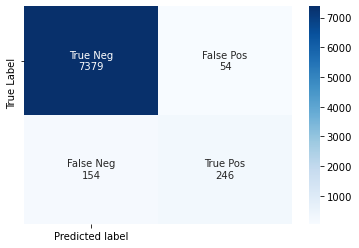

In [28]:
label_names = ['True Neg','False Pos','False Neg','True Pos']
label_counts = cf_matrix.flatten()

labels = [f"{v1}\n{v2}" for v1, v2 in zip(label_names,label_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels,fmt='', cmap='Blues',yticklabels=['True Label'],xticklabels=['Predicted label'])

In [29]:
# Precison Score

precision = precision_score(y_true=val_y, y_pred=y_pred)
print('Precision: ',precision)

Precision:  0.82


In [30]:
# Recall Score

recall = recall_score(y_true=val_y, y_pred=y_pred)
print('Recall: ',recall)

Recall:  0.615


In [31]:
# F1 Score

f1Score = f1_score(y_true=val_y, y_pred=y_pred)
print('F1 Score: ',f1Score)

F1 Score:  0.7028571428571427


### Get Predictions from test data

In [32]:
test_df = pd.read_csv("test_Wf7sxXF.csv")
test_df.head()

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12
0,39162,2022-01-01,2,2,NaN,2021-08-17,1,1,0,0,0,1,0,0,0,0,1,0
1,39163,2022-01-01,4,7,3.0,2020-05-21,1,0,0,0,0,0,0,1,0,0,0,0
2,39164,2022-01-01,8,7,NaN,NaN,0,0,0,0,1,1,0,0,0,0,0,0
3,39165,2022-01-01,9,8,2.0,2020-06-22,0,0,0,0,1,1,1,0,0,0,2,0
4,39166,2022-01-01,4,5,2.0,2021-03-10,1,0,0,0,0,0,0,0,0,0,0,0


In [33]:
print("Shape of Test set ",test_df.shape)

Shape of Test set  (13184, 18)


In [34]:
test_x = test_df[['user_activity_var_1','user_activity_var_2','user_activity_var_4','user_activity_var_5','user_activity_var_8','user_activity_var_9','user_activity_var_11']]
test_x.head()

,user_activity_var_1,user_activity_var_2,user_activity_var_4,user_activity_var_5,user_activity_var_8,user_activity_var_9,user_activity_var_11
0,1,1,0,0,0,0,1
1,1,0,0,0,1,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,2
4,1,0,0,0,0,0,0


In [35]:
test_id = test_df['id'].to_numpy()
test_x = test_x.to_numpy()

In [36]:
print(test_id.shape)
print(test_x.shape)

(13184,)
(13184, 7)


In [37]:
pred = model.predict(test_x)
y_pred = np.argmax(pred, axis=1)

In [38]:
result_df= pd.DataFrame({"id":test_id,"buy":y_pred})

In [39]:
result_df.head()

,id,buy
0,39162,1
1,39163,0
2,39164,0
3,39165,1
4,39166,0


In [40]:
result_df.to_csv('Ashish_result.csv', index=False)